# **Class 11: Retrieval Augmented Generation (RAG)**

In [5]:
from IPython.display import Image, display
project_path = "C:/Users/tiago/OneDrive/Documentos/CapstoneProject/"

## Why RAG?

Retrieval-Augmented Generation (RAG) is an important and useful approach in the field of natural language processing for several reasons:

1. **Enhanced Knowledge Access**: RAG models integrate external knowledge sources (retrieval) with generative models. This combination allows RAG systems to access up-to-date information beyond the training data of the generative model, enabling more accurate and relevant responses, especially in rapidly changing domains.

2. **Adaptability**: RAG setups are flexible and can be easily adapted to new domains or topics by updating the retrieval component, without the need for extensive retraining of the generative model.

3. **Contextual Understanding**: By retrieving and incorporating relevant information, RAG improves a model's contextual understanding, thus generating outputs that consider the nuances and specifics of a given query or task.

## What is RAG?

Retrieval-Augmented Generation (RAG) is a framework in natural language processing that combines the strengths of retrieval-based and generation-based approaches. Specifically, RAG systems utilize both external information retrieval mechanisms and generative models to produce more accurate, informative, and context-aware text outputs. The pipeline of RAG can be divided into two main phases:

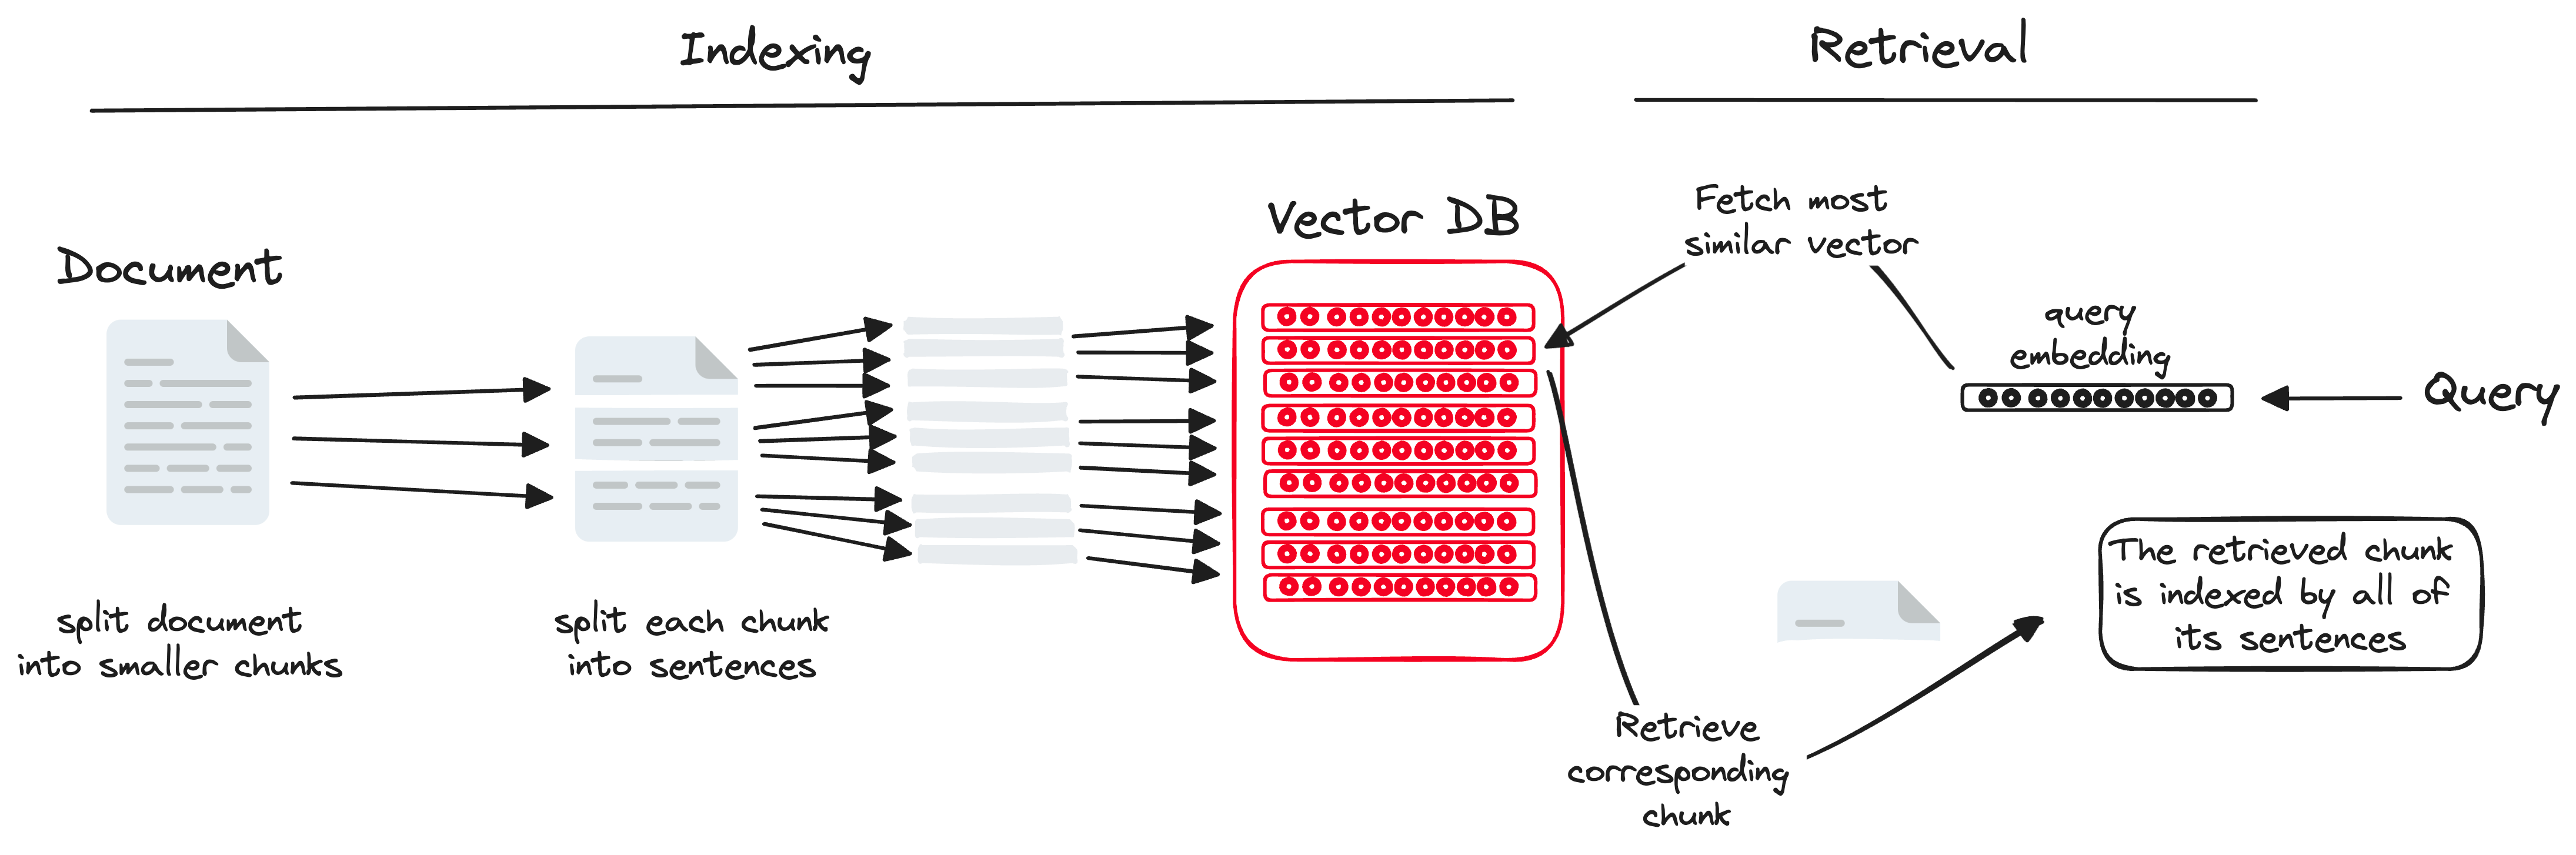

In [7]:
display(Image(filename=project_path+'images/class11/rag1.png', width=1000, height=800))

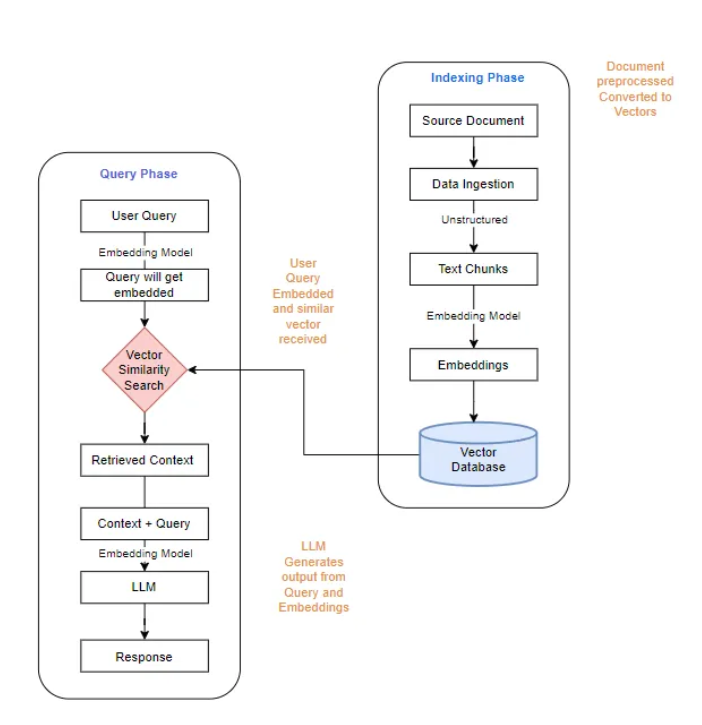

In [8]:
display(Image(filename=project_path+'images/class11/rag2.png', width=600, height=1000))

### Indexing Phase

- **Objective**: The goal of the indexing phase is to prepare the document corpus in such a way that makes future retrieval operations efficient and accurate.

- **Process**:
  1. **Document Encoding**: Each document in the corpus is processed and encoded into a dense vector representation using a pre-trained transformer model or another suitable encoder. This transforms textual documents into mathematical vectors that can be used for efficient similarity calculations.

  2. **Index Construction**: The encoded document vectors are stored in a specialized data structure known as an "index." This index is designed for quick access and similarity searches, optimizing retrieval operations. 

  3. **Storage**: The index is stored in a format that allows it to be easily queried. This often involves organizing the vectors in a manner that reduces the computational complexity of search operations, enabling rapid retrieval of relevant documents during the querying phase.

In [ ]:
%pip install -qU langchain-pinecone

In [ ]:
import os
from typing import List

from dotenv import load_dotenv
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.documents.base import Document
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pinecone import Index, Pinecone

# Load environment variables from a .env file
load_dotenv()


def get_text_from_pdf(pdf_file: str) -> List[Document]:
    """
    Extracts text from a PDF file and returns it as a list of Document objects.

    Args:
        pdf_file (str): Path to the PDF file to be processed.

    Returns:
        List[Document]: A list of Document objects, where each represents a page in the PDF.
    """
    # Initialize the PyMuPDFLoader with the given PDF file
    loader = PyMuPDFLoader(pdf_file)

    # Initialize an empty list to store the pages
    pages: List[Document] = []

    # Iterate over each loaded page and add it to the list
    for page in loader.load():
        pages.append(page)

    # Return the list of extracted pages
    return pages

Next we will  processes all PDF files in the current directory, splits their text into chunks, and stores their embeddings in a Pinecone vector database.

1. Find all PDF files in the current directory.

In [ ]:
# Get a list of all PDF files in the current directory
pdf_files = [f for f in os.listdir() if f.endswith(".pdf")]

2. Extract text from each PDF file.

In [ ]:

# Initialize a list to store all extracted documents
docs: List[Document] = []

# Extract text from each PDF file and add to the docs list
for pdf_file in pdf_files:
    docs.extend(get_text_from_pdf(pdf_file))

3. Split the text into manageable chunks for embedding.

In [ ]:
# Define a text splitter to split the documents into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Maximum size of each chunk
    chunk_overlap=250,  # Overlap between chunks to preserve context
    add_start_index=True,  # Include the starting index of each chunk
)

# Split all documents into smaller chunks
all_splits = text_splitter.split_documents(docs)

This API works with a list of Document objects. Document objects all have page_content and metadata attributes, making them a universal way to store unstructured text and associated metadata.

In [ ]:
len(all_splits)

In [ ]:
all_splits[0].metadata

In [ ]:
print(all_splits[0].page_content)

4. Store the resulting embeddings in a Pinecone vector database.

In [ ]:
embeddings_model = OpenAIEmbeddings()

embeddings = embeddings_model.embed_documents(
    [
        "Hi there!",
        "Oh, hello!",
        "What's your name?",
        "My friends call me World",
        "Hello World!"
    ]
)

len(embeddings), len(embeddings[0])

In [ ]:
# Initialize a connection to Pinecone
pc = Pinecone()
index: Index = pc.Index("rag")  # Access the "rag" index in Pinecone

# Initialize a Pinecone vector store with OpenAI embeddings
vector_store = PineconeVectorStore(
    index=index, embedding=OpenAIEmbeddings(model="text-embedding-3-small")
)

# Generate unique IDs for each chunk
ids = [str(i) for i in range(len(all_splits))]

# Add the documents and their embeddings to the vector store
vector_store.add_documents(documents=all_splits, ids=ids)

### Querying Phase

- **Objective**: In the querying phase, the system efficiently retrieves the most relevant documents from the indexed corpus in response to a specific input query.

- **Process**:
  1. **Query Encoding**: The input query is transformed into a dense vector using the same encoder approach as was used for the document corpus, ensuring that both queries and documents exist in the same vector space.

  2. **Similarity Search**: The query vector is compared against the pre-encoded document vectors in the index to find the most similar documents. This is typically done using similarity metrics such as cosine similarity or Euclidean distance.

  3. **Document Retrieval**: Based on the similarity scores, a selection of top-k documents that best match the query is retrieved. These documents are considered highly relevant and provide the necessary context for the subsequent generation phase in a RAG system.


In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from operator import itemgetter


def format_docs(documents):
    return "\n\n".join(doc.page_content for doc in documents)

In [ ]:
retriever = vector_store.as_retriever(
            search_type="similarity_score_threshold",
            search_kwargs={"k": 1, "score_threshold": 0.5},
        )

Let's setup our 

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")


template = """Use the following pieces of context to answer the question at the end.
            If you don't know the answer, just say that you don't know, don't try to make up an answer.
            Use three sentences maximum and keep the answer as concise as possible.
            You have acess to the previous conversation history to personalize the conversation.

{context}

Question: {question}
"""

custom_rag_prompt = PromptTemplate.from_template(template)

Let's combine components into a RAG chain

In [ ]:
context = itemgetter("customer_input") | retriever | format_docs
first_step = RunnablePassthrough.assign(context=context)
rag_chain = first_step | custom_rag_prompt | llm | StrOutputParser()

In [ ]:
rag_chain.invoke("What are the available payment methods?")

## Evaluating RAG Systems

 Evaluating RAG systems involves assessing both the retrieval and generation components. We will only focus on retrieval metrics, here are some of the simplest metrics commonly used for evaluating RAG models:

   - **Recall@K**: This metric indicates the proportion of relevant documents retrieved among the top K results. A higher recall means that the retrieval component can effectively find relevant information.

   - **Precision@K**: Measures the proportion of relevant documents among the top K retrieved documents. This reflects the accuracy of what's being returned.

## LangChain Documentation

### Document Loader:
- Conceptual Guide: https://python.langchain.com/docs/concepts/document_loaders/
- Integrations: https://python.langchain.com/docs/integrations/document_loaders/#pdfs

### Text Splitter:
- Conceptual Guide: https://python.langchain.com/docs/concepts/text_splitters/

### Embeddings Model:
- Conceptual Guide: https://python.langchain.com/docs/concepts/embedding_models/
- Integrations: https://python.langchain.com/docs/integrations/text_embedding/

### Vector Database:
- Conceptual Guide: https://python.langchain.com/docs/concepts/vectorstores/
- Integrations: https://python.langchain.com/docs/integrations/vectorstores/

### Retriever: 
- Conceptual Guide: https://python.langchain.com/docs/concepts/retrievers/